In [1]:
import os
from random import sample
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Must be set before importing TF to supress messages
os.environ["CUDA_VISIBLE_DEVICES"]= '2'

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
from utils.loader import DataLoader
from utils.tools import test_model
from utils.data_sampler import CustomDataGenerator, CustomIterator
from utils.configs import config
from typing import List
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

def load_VGG_model(img_height: int, img_width: int, lr: int, loss: tf.keras.losses.Loss, metrics: List[str], trainable: True) -> tf.keras.Model:
    """ Loads VGG-16 model.

    Args:
        img_height (int): Image height.
        img_width (int): Image width.
        lr (int): Learning rate.
        loss (tf.keras.losses.Loss): Model loss.
        metrics (List[str]): Training metrics.
        trainable (True): Set if model weights should be kept frozen or not.

    Returns:
        tf.keras.Model: TensorFlow VGG-16 model.
    """
    model = tf.keras.applications.vgg16.VGG16(input_shape=(img_height, img_width, 3))
    model.trainable = trainable
    model.compile(optimizer=tf.keras.optimizers.Adam(lr, epsilon=0.1),
                loss=loss,
                metrics=metrics)

    return model

In [2]:
img_height = 224
img_width = 224
batch_size = 1

# Set augmentation and pre-processing
test_datagen = CustomDataGenerator(
                    preprocessing_function=tf.keras.applications.vgg16.preprocess_input, dtype=tf.float32)

# Load ImageNet dataset with the VGG augmentation
loader = DataLoader(batch_size, (img_height, img_width))
test_set = loader.load_test_set(aug_test=test_datagen, set_batch_size=False)

Loading test set...
Found 48238 images belonging to 1000 classes.


In [3]:
model = load_VGG_model(img_height=224, img_width=224, lr=1e-3, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'], trainable=True)

In [4]:
# Get list of class folders
folder_names = list(os.walk(os.path.join(config['image_net_path'], config['test_path'])))[0][1]

In [5]:
# Get conversion of folder to names
conv_table = pd.read_table(os.path.join(config['externals'], 'imagenet1k_folder2labels.txt'), names=['folder', 'num', 'label'], delim_whitespace=True)
label_dict = dict(zip(list(conv_table['folder']), list(conv_table['label'])))

In [6]:
# Create model to ouput activation at end of block 4
layer_name = 'block4_conv3'
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

In [7]:
test_set.set_target_sampling([folder_names[0]], [1])

In [46]:
activations = intermediate_layer_model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
activations = tf.reshape(activations, [activations.shape[0],-1]).numpy()

Basic Variance of Activations

In [20]:
basic_var_dict = {}
for i, cl in enumerate(label_dict.keys()):
    if i % 25 == 0:
        print(f'{i}/{len(label_dict)}')
    test_set.set_target_sampling([cl], [1])
    activations = intermediate_layer_model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    var = np.var(activations, axis =(1,2)) # Var within each filter
    var = np.var(var, axis=-1) # Var across variance of filters
    var = np.mean(var) # Mean variance across all inter-class samples
    basic_var_dict[label_dict[cl]] = var

In [21]:
basic_var_dict = dict(sorted(basic_var_dict.items(), key=lambda item: item[1], reverse=True))

In [69]:
with open('class_var.pkl', 'wb') as f:
    pickle.dump(basic_var_dict, f)

In [70]:
activations.shape

(46, 28, 28, 512)

In [71]:
a = tf.keras.layers.LayerNormalization(axis=(1,2) , center=True , scale=True)

PCA Version

In [74]:
var_dict = {}
pca = PCA(0.5)
# Perform PCA per class
for i, cl in enumerate(label_dict.keys()):
    if i % 25 == 0:
        print(f'{i}/{len(label_dict)}')
    test_set.set_target_sampling([cl], [1])
    activations = intermediate_layer_model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    activations = a(activations)
    activations = tf.reshape(activations, [activations.shape[0],-1]).numpy()
    reduced = pca.fit(activations)
    var_dict[label_dict[cl]] = pca.n_components_

0/1000
25/1000
50/1000
75/1000
100/1000
125/1000
150/1000
175/1000
200/1000
225/1000
250/1000
275/1000
300/1000
325/1000
350/1000
375/1000
400/1000
425/1000
450/1000
475/1000
500/1000
525/1000
550/1000
575/1000
600/1000
625/1000
650/1000
675/1000
700/1000
725/1000
750/1000
775/1000
800/1000
825/1000
850/1000
875/1000
900/1000
925/1000
950/1000
975/1000


In [49]:
import pickle

In [79]:
with open('class_var_pca_comp.pkl', 'wb') as f:
    pickle.dump(var_dict, f)

In [117]:
with open('external_files/generated_saves/class_var.pkl', 'rb') as f:
    class_var  = pickle.load(f)
with open('external_files/generated_saves/class_var_pca.pkl', 'rb') as f:
    class_var_pca  = pickle.load(f)
with open('external_files/generated_saves/class_var_pca_comp.pkl', 'rb') as f:
    class_var_pca_comp  = pickle.load(f)
with open('external_files/generated_saves/class_acc.pkl', 'rb') as f:
    class_acc = pickle.load(f)

In [78]:
var_dict = dict(sorted(var_dict.items(), key=lambda item: item[1], reverse=True))

Comparisons

In [107]:
var_pca_comp = set(list(var_dict.keys())[:200]) # Explained var threshold set with 50% cap 
var_pca = set(list(class_var_pca.keys())[:200]) # First 5 PC's explained variance sum
base_var = set(list(basic_var_dict.keys())[:200]) # Basic variance
class_acc = set(list(class_acc.keys())[:200]) # Per class accuracies 

In [99]:
overlap = len(base_var.intersection(var_pca))
overlap2 = len(base_var.intersection(var_pca_comp))

In [110]:
len(class_acc.intersection(base_var))

42

In [114]:
print(f'Overlap of lowest 200 (accuracy) classes to highest 200 basic variance:   {len(class_acc.intersection(base_var))}')
print(f'Overlap of lowest 200 (accuracy) classes to lowest 200 cumulative variance of first 5 PCs:   {len(class_acc.intersection(var_pca))}')
print(f'Overlap of lowest 200 (accuracy) classes to lowest 200 first N PCs w/50% expained variance:   {len(class_acc.intersection(var_pca_comp))}')

Overlap of lowest 200 (accuracy) classes to highest 200 basic variance:   42
Overlap of lowest 200 (accuracy) classes to lowest 200 cumulative variance of first 5 PCs:   30
Overlap of lowest 200 (accuracy) classes to lowest 200 first N PCs w/50% expained variance:   24


In [167]:
x_base, x_pca, x_pca_comp, y = [], [], [], []
for cl in list(class_var.keys())[:200]:
    cl_conv = cl #label_dict[cl]
    x_base.append(class_var[cl_conv])
    x_pca.append(class_var_pca[cl_conv])
    x_pca_comp.append(class_var_pca_comp[cl_conv])
    y.append(class_acc[cl_conv])

In [168]:
x_base = (np.array(x_base) - np.min(np.array(x_base)))/(np.max(np.array(x_base)) - np.min(np.array(x_base)))

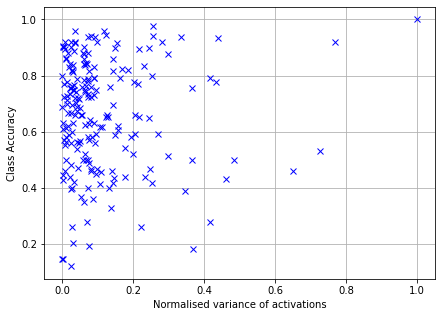

In [170]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_base, y, 'bx')
ax.grid()
ax.set_xlabel('Normalised variance of activations')
ax.set_ylabel('Class Accuracy')
fig.savefig('base_var_plot.png')

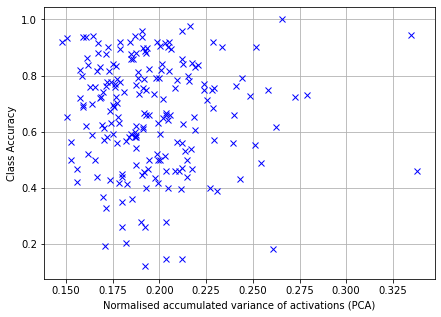

In [171]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_pca, y, 'bx')
ax.grid()
ax.set_xlabel('Normalised accumulated variance of activations (PCA)')
ax.set_ylabel('Class Accuracy')
fig.savefig('pca_var_plot.png')

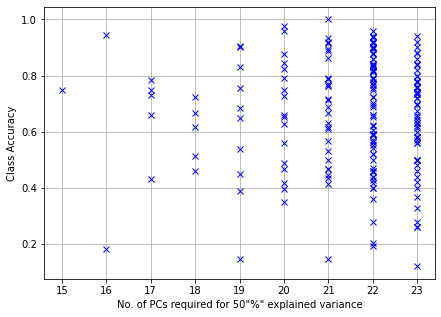

In [172]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_pca_comp, y, 'bx')
ax.grid()
ax.set_xlabel('No. of PCs required for 50"%" explained variance')
ax.set_ylabel('Class Accuracy')
fig.savefig('pca_comp_var_plot.png')

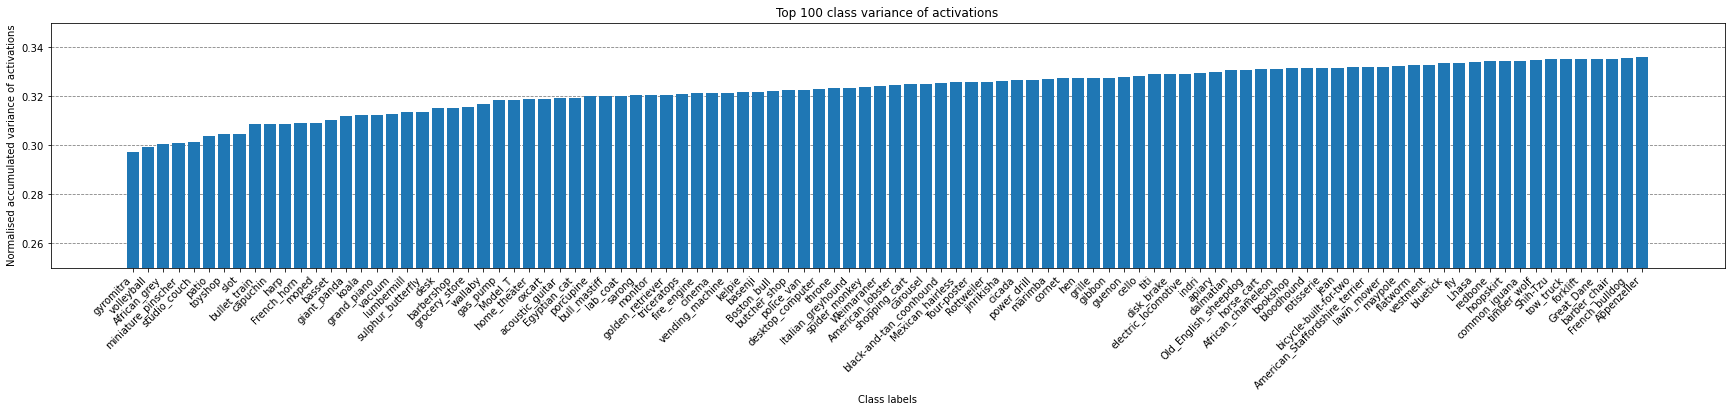

In [77]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.bar(list(var_dict.keys())[:100], list(var_dict.values())[:100]/max(list(var_dict.values())))
ax.set_ylabel('Normalised accumulated variance of activations')
ax.set_xlabel('Class labels')
ax.set_title('Top 100 class variance of activations')
ax.set_ylim([0.25, 0.35])
fig.autofmt_xdate(rotation=45)
fig.savefig('class_var_pca.png')

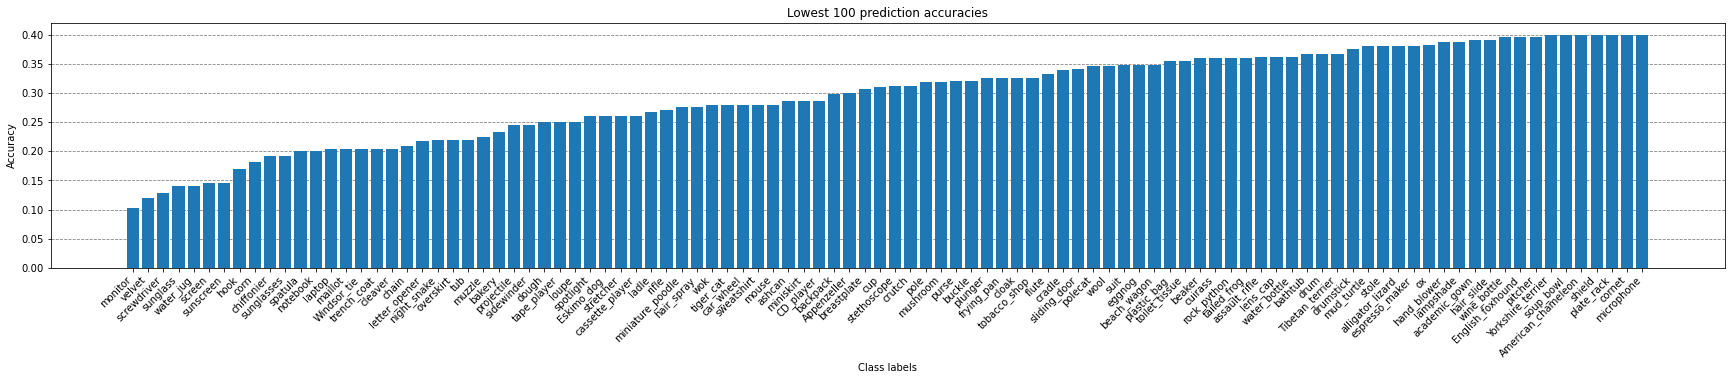

In [16]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.bar(list(class_acc.keys())[:100], list(class_acc.values())[:100])
ax.set_ylabel('Accuracy')
ax.set_xlabel('Class labels')
ax.set_title('Lowest 100 prediction accuracies')
fig.autofmt_xdate(rotation=45)
fig.savefig('class_acc.png')